## 1. Of cats and cookies
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We're not kidding! Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!</p>

In [266]:
# Importing pandas
# ... YOUR CODE FOR TASK 1 ...
import pandas as pd
# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
# ... YOUR CODE FOR TASK 1 ...
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [268]:
# Counting the number of players in each AB group.
# ... YOUR CODE FOR TASK 2 ...
df.groupby('version').userid.count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## 3. The distribution of game rounds
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>It looks like there is roughly the same number of players in each group, nice!</p>
<p>The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.</p>

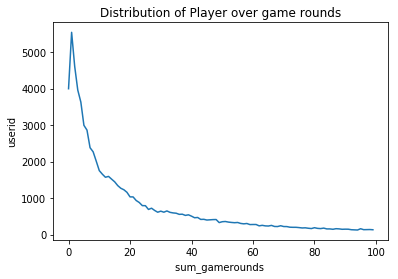

In [270]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds').userid.count()
#plot_df[0:101]
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(title='Distribution of Player over game rounds')
ax.set_xlabel("sum_gamerounds ")
ax.set_ylabel("userid");

## 4. Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>As a first step, let's look at what 1-day retention is overall.</p>

In [272]:
# The % of users that came back the day after they installed
# ... YOUR CODE FOR TASK 4 ...
df['retention_1'].mean()

0.4452095044850259

## 5. 1-day retention by AB-group
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.</p>

In [289]:
# Calculating 1-day retention for each AB-group
# ... YOUR CODE FOR TASK 5 ...
r1_mean = df.groupby('version').retention_1.mean()
r1_std = df.groupby('version').retention_1.std()
r7_mean = df.groupby('version').retention_7.mean()
r7_std = df.groupby('version').retention_7.std()
print(r1_mean,r1_std,r7_mean,r7_std)

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64 version
gate_30    0.497314
gate_40    0.496663
Name: retention_1, dtype: float64 version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64 version
gate_30    0.392464
gate_40    0.385849
Name: retention_7, dtype: float64


## 6. Should we be confident in the difference?
<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?</p>
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

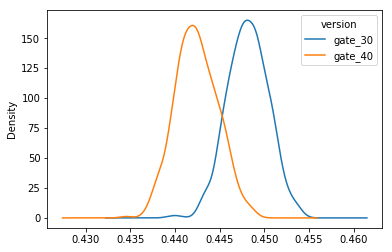

In [276]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version').retention_1.mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
# ... YOUR CODE FOR TASK 6 ...
boot_1d.plot.kde();

## 7. Zooming in on the difference
<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>
<p>(<em>Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.</em>)</p>

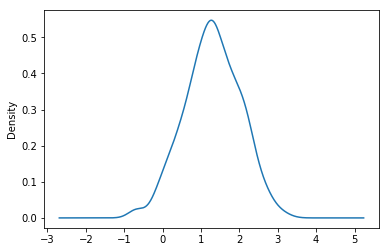

In [278]:
# Adding a column with the % difference between the two AB-groups
A='gate_30'
B='gate_40'
boot_1d['diff'] = (boot_1d[A]-boot_1d[B])/boot_1d[B] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot.kde();
# ... YOUR CODE FOR TASK 7 ...

## 8. The probability of a difference
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [280]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()
# Pretty printing the probability
print(prob)
# ... YOUR CODE FOR TASK 8 ...

0.962


## 9. 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Let's start by calculating 7-day retention for the two AB-groups.</p>

In [282]:
# Calculating 7-day retention for both AB-groups
# ... YOUR CODE FOR TASK 9 ...
df.groupby('version').retention_7.mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

1.0


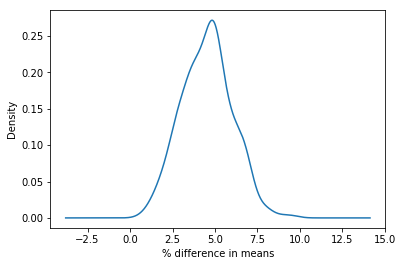

In [284]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version').retention_7.mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
# ... YOUR CODE FOR TASK 10 ...
boot_7d = pd.DataFrame(boot_7d)
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d[A] - boot_7d[B])/boot_7d[B]*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff']>0).mean()

# Pretty printing the probability
# ... YOUR CODE FOR TASK 10 ...
print(prob)

## 11.  The conclusion
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>

In [286]:
# So, given the data and the bootstrap analysis
# Should we move the gate from level 30 to level 40 ?
move_to_level_40 = False